In [1]:
# Dynamicky pridaj src/ do sys.path, nech fungujú importy z vlastných modulov
import sys
import os

# Absolútna cesta k tomuto notebooku
NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))

# Cesta k src/ priečinku, ktorý je o úroveň vyššie
SRC_DIR = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", "src"))
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

In [2]:
# %%
# Global Insights Utilities for Transformer-Based Domain Classifier

import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from captum.attr import IntegratedGradients, NoiseTunnel
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.feature_extraction.text import CountVectorizer
import umap
import matplotlib.pyplot as plt

def compute_attribution_heatmap(model, dataloader: DataLoader, device: torch.device,
                                n_samples: int = 5000, method: str = "ig"):
    """
    Compute mean absolute attribution per token position for each class.
    Returns: {class_idx: mean_attr_array (shape [seq_len])}
    """
    model.eval()
    ig = IntegratedGradients(model)
    nt = NoiseTunnel(ig)
    all_attrs = {c: [] for c in range(model.config.num_labels)}
    count = 0

    for batch in dataloader:
        if count >= n_samples:
            break
        input_ids = batch["input_ids"].to(device)
        mask = batch.get("attention_mask", None)
        labels = batch["label"].cpu().numpy()

        # choose IG or SmoothGrad
        if method == "ig":
            attributions, _ = ig.attribute(
                inputs=input_ids,
                baselines=torch.zeros_like(input_ids),
                target=None,
                return_convergence_delta=True
            )
        else:
            attributions = nt.attribute(
                inputs=input_ids,
                nt_type='smoothgrad_sq',
                stdevs=0.02,
                target=None
            )

        token_attr = attributions.abs().sum(dim=-1).cpu().numpy()  # (B, L)
        for i, lbl in enumerate(labels):
            all_attrs[lbl].append(token_attr[i])
        count += input_ids.size(0)

    mean_attrs = {c: np.mean(np.stack(v, axis=0), axis=0) for c, v in all_attrs.items()}
    return mean_attrs

def plot_heatmap(mean_attrs: dict, figsize=(8,4)):
    """
    Plot a heatmap of mean_attrs: {class_idx: [seq_len]}.
    """
    classes = sorted(mean_attrs.keys())
    data = np.stack([mean_attrs[c] for c in classes], axis=0)
    plt.figure(figsize=figsize)
    plt.imshow(data, aspect='auto')
    plt.xlabel("Token Position")
    plt.ylabel("Class")
    plt.yticks(classes, [f"Class {c}" for c in classes])
    plt.colorbar(label="Mean |Attribution|")
    plt.title("Global Attribution Heatmap")
    plt.tight_layout()
    plt.show()

def extract_surrogate_rules(dataloader: DataLoader, model, tokenizer, max_samples: int = 10000, depth: int = 3):
    """
    Train a shallow decision tree on transformer predictions to extract rules.
    """
    texts, preds = [], []
    for batch in dataloader:
        ids = batch["input_ids"]
        logits = model(input_ids=ids, attention_mask=batch.get("attention_mask"))[0]
        preds.extend(torch.argmax(logits, dim=-1).cpu().tolist())
        # decode back to strings
        for seq in ids:
            texts.append(tokenizer.decode(seq, skip_special_tokens=True))
        if len(texts) >= max_samples:
            break

    texts, preds = texts[:max_samples], preds[:max_samples]
    vec = CountVectorizer(analyzer='char', ngram_range=(3,3), max_features=500)
    X = vec.fit_transform(texts)
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X, preds)

    rules = export_text(tree, feature_names=vec.get_feature_names_out())
    print("Surrogate Decision Tree Rules:\n")
    print(rules)

def project_embeddings(model, dataloader: DataLoader, device: torch.device, n_samples: int = 3000):
    """
    UMAP projection of the model's pooled token embeddings.
    Returns: emb2d (n_samples×2), labels
    """
    model.eval()
    embs, labels = [], []
    for batch in dataloader:
        ids = batch["input_ids"].to(device)
        outs = model(input_ids=ids, attention_mask=batch.get("attention_mask"), output_hidden_states=True)
        last = outs.hidden_states[-1]   # (B, L, D)
        pooled = last.mean(dim=1).cpu().numpy()
        embs.append(pooled)
        labels.extend(batch["label"].tolist())
        if sum(e.shape[0] for e in embs) >= n_samples:
            break

    embs = np.vstack(embs)[:n_samples]
    labels = labels[:n_samples]
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
    emb2d = reducer.fit_transform(embs)
    return emb2d, labels

def plot_embedding(emb2d: np.ndarray, labels: list):
    """
    Scatter-plot 2D embeddings colored by label.
    """
    plt.figure(figsize=(6,6))
    for c in sorted(set(labels)):
        idx = [i for i, lbl in enumerate(labels) if lbl == c]
        plt.scatter(emb2d[idx,0], emb2d[idx,1], label=f"Class {c}", alpha=0.5, s=5)
    plt.legend()
    plt.title("UMAP Projection of Model Embeddings")
    plt.tight_layout()
    plt.show()


/home/fetagpu/miniconda3/envs/igpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# %%
import torch
import numpy as np
from captum.attr import IntegratedGradients, NoiseTunnel

def compute_attribution_heatmap(model, dataloader, device, n_samples=5000, method="ig"):
    """
    Compute mean absolute attribution per token position for each class,
    attributing on the input embeddings (floats) rather than integer IDs.
    Returns: {class_idx: mean_attr_array (shape [seq_len])}
    """
    model.eval()
    embed_layer = model.get_input_embeddings()
    
    def forward_emb(inputs_embeds, attention_mask):
        return model(inputs_embeds=inputs_embeds, attention_mask=attention_mask).logits
    
    ig = IntegratedGradients(forward_emb)
    nt = NoiseTunnel(ig)
    all_attrs = {c: [] for c in range(model.config.num_labels)}
    seen = 0

    for batch in dataloader:
        if seen >= n_samples:
            break
        input_ids = batch["input_ids"].to(device)
        mask = batch.get("attention_mask", None)
        mask = mask.to(device) if mask is not None else None

        # Obtain embeddings and enable gradient
        emb = embed_layer(input_ids)
        emb.requires_grad_(True)
        baseline = torch.zeros_like(emb)

        # Determine targets per-sample
        with torch.no_grad():
            logits = model(input_ids=input_ids, attention_mask=mask).logits
            preds = logits.argmax(dim=-1)

        # Compute attributions
        if method == "ig":
            attributions = ig.attribute(
                inputs=emb,
                baselines=baseline,
                target=preds,
                additional_forward_args=(mask,),
                return_convergence_delta=False
            )
        else:
            attributions = nt.attribute(
                inputs=emb,
                baselines=baseline,
                target=preds,
                additional_forward_args=(mask,),
                nt_type='smoothgrad_sq',
                stdevs=0.02
            )
        
        # Sum over embedding dim, detach before converting to NumPy
        token_attr = attributions.abs().sum(dim=-1).detach().cpu().numpy()  # (B, L)
        labels = preds.cpu().numpy()

        for i, lbl in enumerate(labels):
            all_attrs[lbl].append(token_attr[i])
        seen += emb.size(0)

    mean_attrs = {
        c: np.mean(np.stack(v, axis=0), axis=0)
        for c, v in all_attrs.items() if v
    }
    return mean_attrs


In [4]:
# %%
# Updated extract_surrogate_rules with device handling

import torch
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.feature_extraction.text import CountVectorizer

def extract_surrogate_rules(dataloader, model, tokenizer, device, max_samples=10000, depth=3):
    """
    Featurize domains as character 3-grams, train a decision tree on the model's predictions,
    and print human-readable rules. Ensures tensors and model are on the same device.
    """
    model.eval()
    texts, preds = [], []

    with torch.no_grad():
        for batch in dataloader:
            # Move inputs to the same device as the model
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch.get("attention_mask")
            if attention_mask is not None:
                attention_mask = attention_mask.to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits if hasattr(outputs, "logits") else outputs[0]
            batch_preds = torch.argmax(logits, dim=-1).cpu().tolist()
            preds.extend(batch_preds)

            # Decode back to strings (move to CPU first)
            for seq in input_ids:
                texts.append(tokenizer.decode(seq.cpu(), skip_special_tokens=True))

            if len(texts) >= max_samples:
                break

    texts = texts[:max_samples]
    preds = preds[:max_samples]

    # Vectorize as char 3-grams
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 3), max_features=500)
    X = vectorizer.fit_transform(texts)

    # Train a shallow decision tree as surrogate
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X, preds)

    # Print rules
    rules = export_text(tree, feature_names=vectorizer.get_feature_names_out())
    print("Surrogate Decision Tree Rules:\n")
    print(rules)

# Invocation example:
# extract_surrogate_rules(dataloader, model, tokenizer, DEVICE)


In [5]:
# %%
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt

def project_embeddings(model, dataloader, device, n_samples=3000):
    """
    UMAP projection of the model's pooled token embeddings.
    Returns: emb2d (n_samples×2), labels
    """
    model.eval()
    embs, labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            # Move inputs to the same device
            input_ids = batch["input_ids"].to(device)
            attn_mask = batch.get("attention_mask")
            if attn_mask is not None:
                attn_mask = attn_mask.to(device)

            # Forward with hidden states
            outputs = model(
                input_ids=input_ids,
                attention_mask=attn_mask,
                output_hidden_states=True
            )
            hidden = outputs.hidden_states[-1]  # (B, L, D)

            # Pool and detach before converting to NumPy
            pooled = hidden.mean(dim=1).detach().cpu().numpy()  # (B, D)
            embs.append(pooled)

            # Collect labels on CPU
            labels.extend(batch["label"].cpu().tolist())

            if sum(e.shape[0] for e in embs) >= n_samples:
                break

    # Stack and truncate
    embs = np.vstack(embs)[:n_samples]
    labels = labels[:n_samples]

    # UMAP reduction
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
    emb2d = reducer.fit_transform(embs)

    return emb2d, labels

def plot_embedding(emb2d: np.ndarray, labels: list):
    """
    Scatter-plot 2D embeddings colored by label.
    """
    plt.figure(figsize=(6,6))
    for c in sorted(set(labels)):
        idx = [i for i, lbl in enumerate(labels) if lbl == c]
        plt.scatter(emb2d[idx,0], emb2d[idx,1], label=f"Class {c}", alpha=0.5, s=5)
    plt.legend()
    plt.title("UMAP Projection of Model Embeddings")
    plt.tight_layout()
    plt.show()



In [6]:
# %%
# Next-Step Analysis Utilities for Your Domain Detection Pipeline

import torch
import numpy as np
import pandas as pd
import math
from collections import Counter

def get_model_predictions(model, dataloader, device):
    """Run the model on the dataloader and return lists of preds and texts."""
    model.eval()
    preds = []
    texts = []
    # Assuming dataset has attribute .texts aligned with batches
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attn = batch.get("attention_mask")
        if attn is not None:
            attn = attn.to(device)
        with torch.no_grad():
            logits = model(input_ids=input_ids, attention_mask=attn).logits
            batch_preds = torch.argmax(logits, dim=-1).cpu().tolist()
        preds.extend(batch_preds)
    # Extract raw texts from dataset
    if hasattr(dataloader.dataset, "texts"):
        texts = dataloader.dataset.texts[: len(preds)]
    return preds, texts

def get_raw_embeddings(model, dataloader, device, n_samples=3000):
    """
    Get the pooled embeddings (mean over token dimension), labels, and texts.
    Returns:
      embs: np.ndarray of shape (n_samples, hidden_dim)
      labels: list of ints
      texts: list of strings
    """
    model.eval()
    embs, labels, texts = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attn = batch.get("attention_mask")
            if attn is not None:
                attn = attn.to(device)
            outs = model(input_ids=input_ids, attention_mask=attn, output_hidden_states=True)
            last = outs.hidden_states[-1]     # (B, L, D)
            pooled = last.mean(dim=1).cpu().numpy()
            embs.append(pooled)
            labels.extend(batch["label"].cpu().tolist())
            # texts aligned to embeddings
            if hasattr(dataloader.dataset, "texts"):
                texts.extend(dataloader.dataset.texts[len(texts): len(texts) + pooled.shape[0]])
            if sum(e.shape[0] for e in embs) >= n_samples:
                break
    embs = np.vstack(embs)[:n_samples]
    labels = labels[:n_samples]
    texts = texts[:n_samples]
    return embs, labels, texts

def find_ambiguous_domains(emb2d, labels, preds, texts, x_bounds=(2,5)):
    """
    Return domains whose UMAP x-coordinate lies in x_bounds,
    along with their true label and predicted label.
    """
    ambiguous = []
    for i, (x, y) in enumerate(emb2d):
        if x_bounds[0] <= x <= x_bounds[1]:
            ambiguous.append({
                "index": i,
                "domain": texts[i],
                "true": labels[i],
                "pred": preds[i]
            })
    return pd.DataFrame(ambiguous)

def extract_prototypes(embs, labels, texts):
    """
    For each class c, find the text whose embedding is nearest
    to the class centroid.
    Returns a dict {class: prototype_domain}.
    """
    prototypes = {}
    for c in sorted(set(labels)):
        idxs = [i for i,l in enumerate(labels) if l == c]
        class_embs = embs[idxs]
        centroid = class_embs.mean(axis=0)
        dists = np.linalg.norm(class_embs - centroid, axis=1)
        nn_rel = np.argmin(dists)
        prototypes[c] = texts[idxs[nn_rel]]
    return prototypes

def domain_entropy(domain):
    """Compute Shannon entropy of characters in the domain."""
    freqs = Counter(domain)
    probs = [cnt/len(domain) for cnt in freqs.values()]
    return -sum(p * math.log2(p) for p in probs)

def featurize_domains(texts):
    """
    Create a DataFrame of engineered features:
      - length: number of characters
      - entropy: Shannon char-entropy
    """
    data = {
        "domain": texts,
        "length": [len(t) for t in texts],
        "entropy": [domain_entropy(t) for t in texts]
    }
    return pd.DataFrame(data)

# Example Invocation:
# DEVICE = torch.device("cpu")
# preds, texts = get_model_predictions(model, dataloader, DEVICE)
# embs, labels, texts = get_raw_embeddings(model, dataloader, DEVICE)
# from umap import UMAP
# emb2d = UMAP(n_neighbors=15, min_dist=0.1).fit_transform(embs)
#
# # 1) Error-case deep dive
# df_ambig = find_ambiguous_domains(emb2d, labels, preds, texts, x_bounds=(2,5))
# display(df_ambig.head())
#
# # 2) Prototype extraction
# prototypes = extract_prototypes(embs, labels, texts)
# print("Class prototypes:", prototypes)
#
# # 3) Feature engineering
# df_feats = featurize_domains(texts)
# display(df_feats.head())



In [7]:
# %%
# Invocation Cell for Next-Step Analysis in Jupyter

import torch
import pandas as pd
from torch.utils.data import DataLoader
from umap import UMAP

# Import your analysis utilities
from data.datasets import DomainDataset
from transformers import AutoTokenizer
from models.transformer_model_factory import get_transformer_model

# ── Configuration ────────────────────────────────────────────────────────────
DATA_CSV    = "../../datasets/phishing/dns_phishing_preprocessed.csv"
MODEL_NAME  = "distilbert-base-uncased"
MODEL_TYPE  = "standard"   # or "custom-char"/"custom-ngram"
CHECKPOINT  = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt"
BATCH_SIZE  = 32
MAX_LENGTH  = 10           # must match your tokenizer/model
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── 1) Prepare DataLoader ───────────────────────────────────────────────────
df = pd.read_csv(DATA_CSV)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
dataset   = DomainDataset(df, tokenizer=tokenizer, max_length=MAX_LENGTH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# ── 2) Load Model ───────────────────────────────────────────────────────────
model = get_transformer_model(
    MODEL_NAME,
    num_labels=2,           # binary phishing/benign
    model_type=MODEL_TYPE,
    vocab_size=getattr(tokenizer, "vocab_size", None),
    max_length=MAX_LENGTH,
    pad_token_id=getattr(tokenizer, "pad_token_id", 0),
).to(DEVICE)
model.load_state_dict(torch.load(CHECKPOINT, map_location=DEVICE))

# ── 3) Predictions & Texts ─────────────────────────────────────────────────
preds, texts = get_model_predictions(model, dataloader, DEVICE)
print(f"Collected {len(preds)} predictions.")

# ── 4) Embeddings, Labels, Texts ───────────────────────────────────────────
embs, labels, texts_emb = get_raw_embeddings(model, dataloader, DEVICE)
print(f"Pooled {embs.shape[0]} embeddings (dim {embs.shape[1]}).")

# ── 5) UMAP Projection ──────────────────────────────────────────────────────
reducer = UMAP(n_neighbors=15, min_dist=0.1)
emb2d = reducer.fit_transform(embs)
print("Computed 2D UMAP projection.")

# ── 6) Error-Case Deep Dive ─────────────────────────────────────────────────
df_ambig = find_ambiguous_domains(emb2d, labels, preds, texts_emb, x_bounds=(2,5))
print("Ambiguous domain examples:")
display(df_ambig.head())

# ── 7) Prototype Extraction ─────────────────────────────────────────────────
prototypes = extract_prototypes(embs, labels, texts_emb)
print("Class prototypes:")
for cls, dom in prototypes.items():
    print(f"  Class {cls}: {dom}")

# ── 8) Feature Engineering Snapshot ────────────────────────────────────────
df_feats = featurize_domains(texts_emb)
print("Sample engineered features:")
display(df_feats.head())

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [ ]:
# %%
# SHAP per‐token attributions on CPU

import shap
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# ── Configuration ────────────────────────────────────────────────────────────
MODEL_NAME = "distilbert-base-uncased"
CHECKPOINT = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt"
MAX_LENGTH = 10

# ── 1) Force CPU device ──────────────────────────────────────────────────────
DEVICE = torch.device("cpu")

# ── 2) Load model & tokenizer ───────────────────────────────────────────────
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.load_state_dict(torch.load(CHECKPOINT, map_location="cpu"))
model.to(DEVICE)
model.eval()

# ── 3) Prediction function for SHAP ─────────────────────────────────────────
def f(texts):
    """
    Map list of domains → probability of class “1” (phishing).
    """
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    return torch.softmax(logits, dim=-1)[:, 1].cpu().numpy()

# ── 4) Build SHAP explainer ─────────────────────────────────────────────────
masker = shap.maskers.Text(tokenizer)  
explainer = shap.Explainer(f, masker, output_names=["benign", "phishing"])

# ── 5) Explain some domains ─────────────────────────────────────────────────
# domains = [
#     "[CLS] domain: lowcarb.institute [SEP] MX: smtpin.rzone.de [SEP] NS: docks05.rzone.de, shades19.rzone.de [SEP] SOA: primary_ns: shades19.rzone.de | resp_mailbox_dname: hostmaster.strato-rz.de [SEP] zone_SOA: NA [SEP] remarks: zone: lowcarb.institute [SEP]",
#     "[CLS] domain: fikt.uklo.edu.mk [SEP] MX: NA [SEP] NS: NA [SEP] SOA: NA [SEP] zone_SOA: primary_ns: shiroka.uklo.edu.mk | resp_mailbox_dname: administrator.uklo.edu.mk [SEP] remarks: zone: uklo.edu.mk [SEP]"
# ]
# Suppose your raw texts live in a DataFrame column:
raw_series = df["input_string"]    # or whatever your column is called

# 1) Force everything to Python str
all_texts: list[str] = raw_series.astype(str).tolist()

# 2) Take a small batch to explain
domains: list[str] = all_texts[:2]

# 3) Quick sanity check:
print(type(domains), type(domains[0]))
#    should print: <class 'list'> <class 'str'>

# 4) Now call SHAP
shap_values = explainer(domains)

# 5) And visualize
shap.plots.text(shap_values[0])



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<class 'list'> <class 'str'>


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/fetagpu/miniconda3/envs/igpu/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


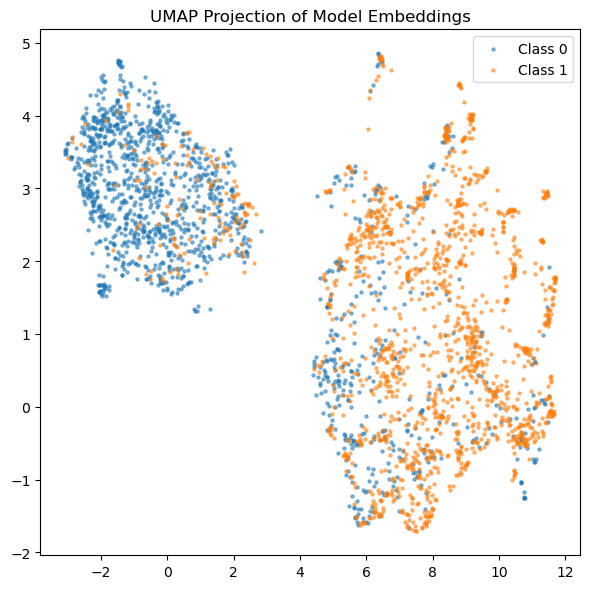

In [ ]:
# %%
# Invocation of Global Insights on Your Domain Classifier

import torch
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

from data.datasets import DomainDataset
from models.transformer_model_factory import get_transformer_model

# ── Configuration ────────────────────────────────────────────────────────────
DATA_CSV       = "../../datasets/phishing/dns_phishing_preprocessed.csv"
MODEL_NAME  = "distilbert-base-uncased"         # or your pretrained model
MODEL_TYPE  = "standard"                        # or "custom-char"/"custom-ngram"
CHECKPOINT     = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt" 
BATCH_SIZE  = 32
MAX_LENGTH  = 10                                # must match your tokenizer/model
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── 1) Load Data ────────────────────────────────────────────────────────────
df = pd.read_csv(DATA_CSV)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
dataset   = DomainDataset(df, tokenizer=tokenizer, max_length=MAX_LENGTH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# ── 2) Load Model ───────────────────────────────────────────────────────────
# Note: supply vocab_size & pad_token_id when using custom models
model = get_transformer_model(
    MODEL_NAME,
    num_labels=2,
    model_type=MODEL_TYPE,
    vocab_size=getattr(tokenizer, "vocab_size", None),
    max_length=MAX_LENGTH,
    pad_token_id=getattr(tokenizer, "pad_token_id", 0)
).to(DEVICE)
model.load_state_dict(torch.load(CHECKPOINT, map_location=DEVICE))

# ── 3) Aggregated Attribution Heatmap ───────────────────────────────────────
# mean_attrs = compute_attribution_heatmap(model, dataloader, DEVICE)
# plot_heatmap(mean_attrs)

# ── 4) Surrogate Rule Extraction ────────────────────────────────────────────
# extract_surrogate_rules(dataloader, model, tokenizer, DEVICE)

# ── 5) Embedding-Space Projection ───────────────────────────────────────────
emb2d, labels = project_embeddings(model, dataloader, DEVICE)
plot_embedding(emb2d, labels)


In [11]:
# %%
# 🎨 Interpretability Demo Notebook (revised)

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients, LayerIntegratedGradients, visualization as viz
import shap
from lime.lime_text import LimeTextExplainer
from bertviz import head_view

# ── 1) Configuration ─────────────────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt"
PRETRAINED_NAME  = "distilbert-base-uncased"
DEVICE           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LENGTH       = 128
NUM_LABELS       = 2  # benign vs malicious

# ── 2) Load tokenizer + model ────────────────────────────────────────────────
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(
                 PRETRAINED_NAME,
                 num_labels=NUM_LABELS,
                 output_attentions=True      # needed for bertviz
             ).to(DEVICE)
# overwrite the head with your fine-tuned weights:
state = torch.load(MODEL_CHECKPOINT, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# ── 3) A raw sample (no [CLS]/[SEP]) ────────────────────────────────────────
sample = "lowcarb.institute MX: smtpin.rzone.de NS: docks05.rzone.de"

# ── 4) Attention Visualization (BertViz) ───────────────────────────────────
def show_attention(text):
    encoding = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH
    ).to(DEVICE)
    outputs = model(**encoding)
    attns   = outputs.attentions   # tuple of (batch, heads, seq, seq)
    tokens  = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])
    head_view(attns, tokens)

# ── 5) SHAP per‐token attributions ──────────────────────────────────────────
# 5.1 Pred fn must accept List[str] (or array of strs), return np.array of shape (n,2)
def f(texts):
    texts = list(texts)  # ensure a plain Python list of str
    enc   = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH
    ).to(DEVICE)
    with torch.no_grad():
        logits = model(**enc).logits
    return torch.softmax(logits, dim=-1).cpu().numpy()

masker    = shap.maskers.Text(tokenizer)  
explainer = shap.Explainer(f, masker, output_names=["benign","malicious"])

def shap_explain(text):
    shap_vals = explainer([text])
    shap.plots.text(shap_vals[0])

# ── 6) LIME Explanations ─────────────────────────────────────────────────────
def lime_explain(text):
    explainer = LimeTextExplainer(class_names=["benign","malicious"])
    def pred_fn(texts):
        enc = tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH
        ).to(DEVICE)
        with torch.no_grad():
            logits = model(**enc).logits
        return torch.softmax(logits, dim=-1).cpu().numpy()

    exp = explainer.explain_instance(
        text_instance=text,
        classifier_fn=pred_fn,
        num_features=10,
        num_samples=500
    )
    return exp.show_in_notebook()

# ── 7) Integrated Gradients (on embeddings) ─────────────────────────────────
# build embedding‐based forward
embeddings = model.get_input_embeddings()
# 1) Re-define your embedding-based forward so it returns all logits:
def forward_emb(inputs_embeds, attn_mask):
    out = model(inputs_embeds=inputs_embeds, attention_mask=attn_mask)
    return out.logits  # shape: (batch, num_labels)

# 2) Re-create IG on that forward:
ig = IntegratedGradients(forward_emb)

def ig_explain(text):
    # 1) Tokenize & embed
    enc     = tokenizer(
                  text,
                  return_tensors="pt",
                  padding=True,
                  truncation=True,
                  max_length=MAX_LENGTH
              ).to(DEVICE)
    emb     = model.get_input_embeddings()(enc["input_ids"])
    emb.requires_grad_(True)
    baseline = torch.zeros_like(emb)

    # 2) Compute IG (returns attributions and convergence delta)
    atts, delta = ig.attribute(
        inputs=emb,
        baselines=baseline,
        additional_forward_args=(enc["attention_mask"],),
        target=1,             # class index for “malicious”
        return_convergence_delta=True,
        n_steps=50
    )

    # 3) Aggregate per-token scores
    scores = atts.abs().sum(dim=-1).squeeze(0).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])

    # 4) Build a VisualizationDataRecord with *8* args:
    record = viz.VisualizationDataRecord(
        scores,                                              # 1) attributions per token
        torch.softmax(model(**enc).logits, dim=-1)[0,1].item(),  # 2) pred probability for class 1
        "malicious",                                         # 3) predicted class name
        "malicious",                                         # 4) true class name (for demo)
        "malicious",                                         # 5) attribute‐for class name
        float(scores.sum()),                                 # 6) summed attribution score
        tokens,                                              # 7) list of tokens
        float(delta.item())                                  # 8) convergence delta
    )

    # 5) Visualize
    viz.visualize_text([record])

# Re-instantiate LayerIntegratedGradients on the same forward_emb & embedding layer
# Replace your existing LIG setup with this:

# 1) Hook LIG on the full embeddings module, not the raw table
lig = LayerIntegratedGradients(forward_emb, model.distilbert.embeddings)

def lig_explain(text: str, n_steps: int = 50):
    # Tokenize
    enc = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH
    ).to(DEVICE)

    # Build embeddings & baseline
    emb      = model.get_input_embeddings()(enc["input_ids"])
    baseline = torch.zeros_like(emb).to(DEVICE)

    # 2) Run LIG
    atts, delta = lig.attribute(
        inputs=emb,
        baselines=baseline,
        additional_forward_args=(enc["attention_mask"],),
        target=1,       # malicious index
        n_steps=n_steps,
        return_convergence_delta=True
    )

    # 3) Aggregate & plot
    scores = atts.abs().sum(dim=-1).squeeze(0).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])

    plt.figure(figsize=(12,2))
    plt.bar(range(len(scores)), scores, alpha=0.8)
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.title(f"Layer‐Integrated Gradients (Δ={delta.item():.2e})")
    plt.show()


# ── 9) Try them out ─────────────────────────────────────────────────────────
# Uncomment whichever you want to run:
# show_attention(sample)
# shap_explain(sample)
# lime_explain(sample)
# ig_explain(sample)
# lig_explain(sample)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
show_attention(sample)
 

DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<IPython.core.display.Javascript object>

In [3]:
shap_explain(sample)


In [4]:
lime_explain(sample)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients, visualization

# ── 1) Configuration ─────────────────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt"
PRETRAINED_NAME  = "distilbert-base-uncased"
DEVICE           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LENGTH       = 128
NUM_LABELS       = 2  # benign vs malicious

# ── 2) Load tokenizer + model ────────────────────────────────────────────────
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    PRETRAINED_NAME,
    num_labels=NUM_LABELS,
    output_attentions=True  # if you also want to visualize attention later
).to(DEVICE)

# overwrite the head with your fine-tuned weights:
state = torch.load(MODEL_CHECKPOINT, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# ── 3) Prepare a wrapper forward function ────────────────────────────────────
def forward_fn(input_ids, attention_mask):
    """
    Given tokenized input, returns the logit for the 'malicious' class (index 1).
    """
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    # logits shape: (batch_size, NUM_LABELS)
    return outputs.logits[:, 1]

# ── 4) Tokenize a sample domain ───────────────────────────────────────────────
sample = "phishy-example.com"
enc = tokenizer(
    sample,
    return_tensors="pt",
    truncation=True,
    max_length=MAX_LENGTH,
    padding="max_length"
).to(DEVICE)

input_ids = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ── 5) Instantiate Integrated Gradients ──────────────────────────────────────
ig = IntegratedGradients(forward_fn)

# ── 6) Compute attributions ─────────────────────────────────────────────────
# Use a “baseline” of all-pad tokens
# bb


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [1]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from captum.attr import Saliency, IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np


/home/fetagpu/miniconda3/envs/igpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_CHECKPOINT = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [3]:
import torch
import numpy as np
from captum.attr import IntegratedGradients

# ——— your domain + tokenization ———
domain = "[CLS] domain: tvetreform.org.pk [SEP] MX: mx2.titan.email, mx1.titan.email [SEP] NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] SOA: primary_ns: brenda.ns.cloudflare.com | resp_mailbox_dname: dns.cloudflare.com [SEP] zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"

enc = tokenizer(domain, return_tensors="pt")
input_ids = enc["input_ids"]           # shape [1, L]
attention_mask = enc["attention_mask"] # shape [1, L]

# ——— pull out the embedding vectors ———
# gets float embeddings, shape [1, L, D]
embeddings = model.distilbert.embeddings.word_embeddings(input_ids)
embeddings.requires_grad_(True)

# ——— baseline for IG (zeros work fine) ———
baseline_embeds = torch.zeros_like(embeddings)

# ——— wrapper forwarding from embeddings ———
def forward_from_embeds(inputs_embeds, attention_mask):
    # note: pass input_ids=None, and inputs_embeds=your tensor
    outputs = model(
        input_ids=None,
        attention_mask=attention_mask,
        inputs_embeds=inputs_embeds
    )
    # return the logit for the “malicious” class (index 1)
    return outputs.logits[:, 1]

# ——— instantiate and run Integrated Gradients ———
ig = IntegratedGradients(forward_from_embeds)

# attribute() returns (attributions, convergence_delta)
attributions, delta = ig.attribute(
    inputs=embeddings,                # the float tensor with grad
    baselines=baseline_embeds,        # same shape
    additional_forward_args=(attention_mask,),
    n_steps=50,                       # you can tune steps for smoother curve
    return_convergence_delta=True
)

# ——— collapse embedding‐dim: one score per token ———
# attributions shape: [1, L, D] → sum over D → [1, L] → squeeze → [L]
token_attributions = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()

print("Tokens:", tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist()))
print("Attribution scores:", np.round(token_attributions, 3))


Tokens: ['[CLS]', '[CLS]', 'domain', ':', 'tv', '##et', '##re', '##form', '.', 'org', '.', 'p', '##k', '[SEP]', 'mx', ':', 'mx', '##2', '.', 'titan', '.', 'email', ',', 'mx', '##1', '.', 'titan', '.', 'email', '[SEP]', 'ns', ':', 'brenda', '.', 'ns', '.', 'cloud', '##fl', '##are', '.', 'com', ',', 'ko', '##lton', '.', 'ns', '.', 'cloud', '##fl', '##are', '.', 'com', '[SEP]', 'so', '##a', ':', 'primary', '_', 'ns', ':', 'brenda', '.', 'ns', '.', 'cloud', '##fl', '##are', '.', 'com', '|', 'res', '##p', '_', 'mail', '##box', '_', 'dna', '##me', ':', 'd', '##ns', '.', 'cloud', '##fl', '##are', '.', 'com', '[SEP]', 'zone', '_', 'so', '##a', ':', 'na', '[SEP]', 'remarks', ':', 'zone', ':', 'tv', '##et', '##re', '##form', '.', 'org', '.', 'p', '##k', '[SEP]', '[SEP]']
Attribution scores: [-0.065  0.068  0.302  0.092 -0.542 -0.676  0.124  0.076 -0.387  0.088
 -0.415 -0.092 -0.008 -0.546  0.013 -0.042  0.044 -0.076  0.122 -0.001
 -0.026  0.003  0.092 -0.058 -0.203  0.109 -0.07  -0.004  0.106 -0

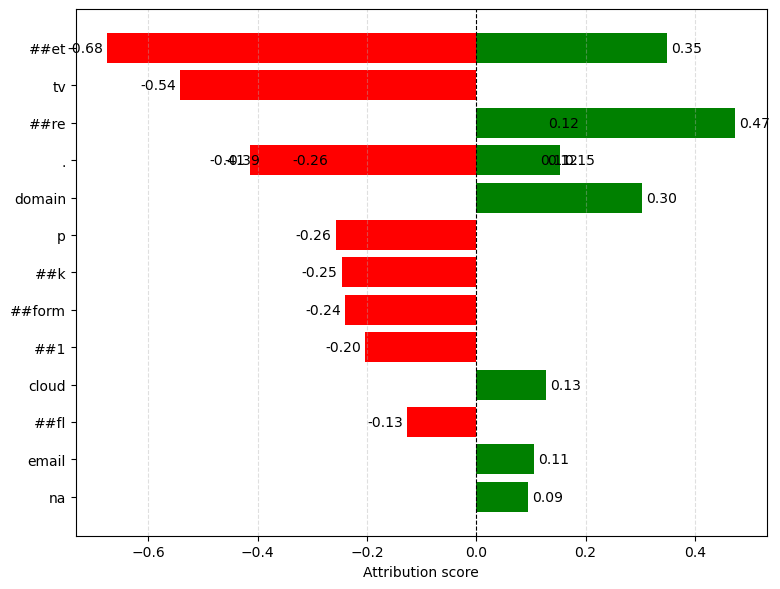

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ——— 4) Align tokens with their attribution scores ———

# Convert back to tokens
all_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
all_scores = token_attributions  # shape: (seq_len,)

# Filter out special tokens ([CLS], [SEP], etc.)
filtered = [
    (tok, score)
    for tok, score in zip(all_tokens, all_scores)
    if tok not in tokenizer.all_special_tokens
]
tokens, scores = zip(*filtered)

# Sort by absolute score descending
order = np.argsort(np.abs(scores))[::-1]
sorted_tokens = [tokens[i] for i in order]
sorted_scores = [scores[i] for i in order]

# ——— 5) Plot horizontal bar chart ———
# — assume `tokens` and `scores` are already defined —
K = 20
order = np.argsort(np.abs(scores))[::-1][:K]
top_tokens = [tokens[i] for i in order]
top_scores = [scores[i] for i in order]

fig, ax = plt.subplots(figsize=(8, 6))
plt.subplots_adjust(left=0.35, right=0.95, top=0.95, bottom=0.05)

bars = ax.barh(
    top_tokens,
    top_scores,
    color=["green" if s > 0 else "red" for s in top_scores],
)
ax.invert_yaxis()  # largest at top
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=3)

ax.set_xlabel("Attribution score")
ax.xaxis.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

/home/fetagpu/miniconda3/envs/igpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


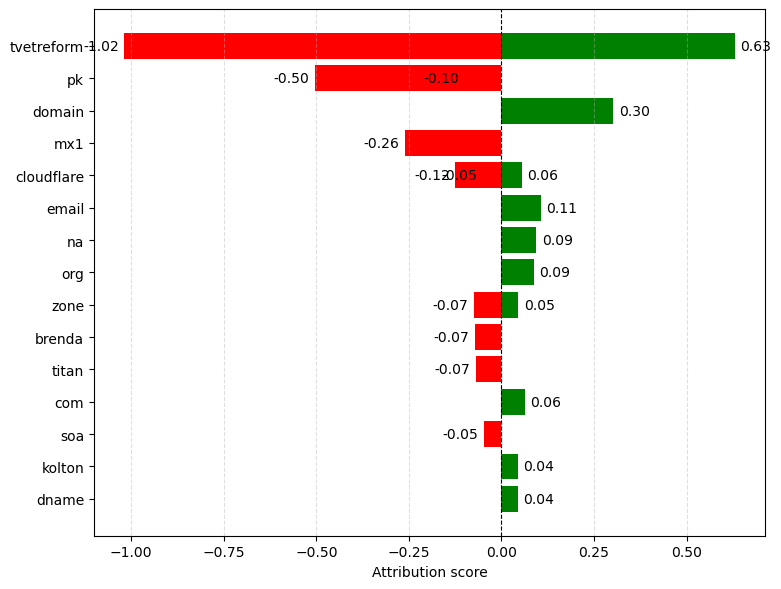

In [1]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 1) load model + tokenizer ───────────────────────────────────────────────

MODEL_CHECKPOINT = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) prepare your DNS record string ─────────────────────────────────────────

domain = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)

enc = tokenizer(domain, return_tensors="pt")
input_ids = enc["input_ids"]           # [1, L]
attention_mask = enc["attention_mask"] # [1, L]

# ─── 3) get embeddings + run IG ───────────────────────────────────────────────

# pull out the embedding vectors
embeds = model.distilbert.embeddings.word_embeddings(input_ids)
embeds.requires_grad_(True)

# zero baseline
baseline = torch.zeros_like(embeds)

# we want the logit for class “1” (malicious)
def forward_from_embeds(inputs_embeds, attention_mask):
    out = model(
        input_ids=None,
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask,
    )
    return out.logits[:, 1]

ig = IntegratedGradients(forward_from_embeds)
attributions, delta = ig.attribute(
    inputs=embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
    return_convergence_delta=True,
)

# collapse last dim → one score per token
token_attrs = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()

raw_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 4) merge subwords + drop pure punctuation ────────────────────────────────

words, word_scores = [], []
for tok, sc in zip(raw_tokens, raw_scores):
    # skip special tokens entirely
    if tok in tokenizer.all_special_tokens:
        continue

    # skip tokens that are only punctuation
    if re.fullmatch(r"[^\w]+", tok):
        continue

    if tok.startswith("##"):
        # append to previous word
        words[-1] += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 5) keep only Top-K by absolute score ───────────────────────────────────────

K = 20
order = np.argsort(np.abs(word_scores))[::-1][:K]
top_words  = [words[i] for i in order]
top_scores = [word_scores[i] for i in order]

# ─── 6) plot with bar_label (matplotlib ≥3.4) ──────────────────────────────────

fig, ax = plt.subplots(figsize=(8, 6))
# give the y-axis a bit more left margin so long labels aren’t clipped:
plt.subplots_adjust(left=0.35, right=0.95, top=0.95, bottom=0.05)

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s > 0 else "red" for s in top_scores],
)
ax.invert_yaxis()  # put largest at top
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=4)
ax.xaxis.grid(True, linestyle="--", alpha=0.4)

ax.set_xlabel("Attribution score")
plt.tight_layout()
plt.show()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


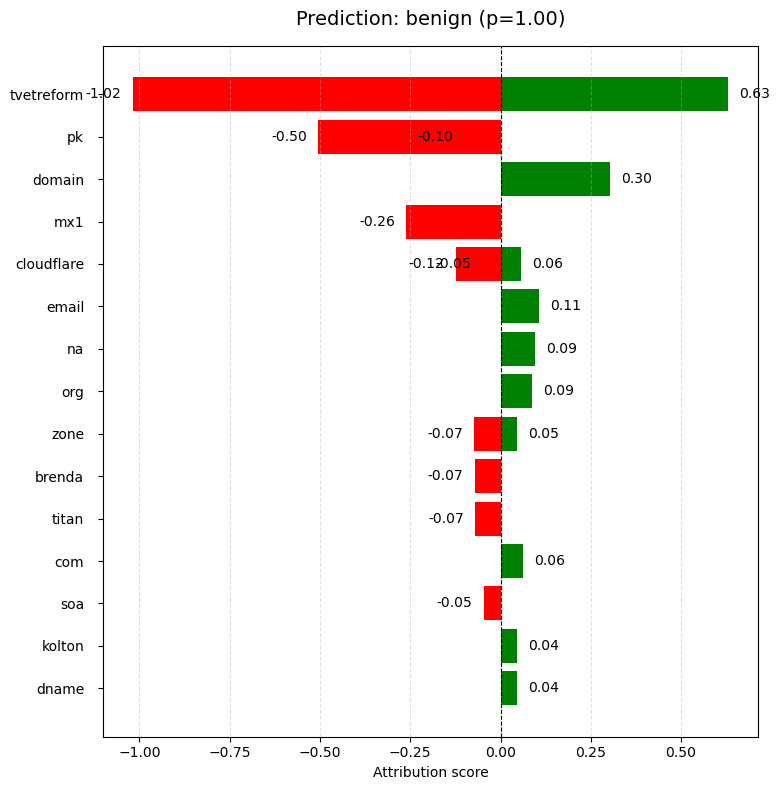

In [7]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 1) load model + tokenizer ───────────────────────────────────────────────

MODEL_CHECKPOINT = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) prepare your DNS‐record string ─────────────────────────────────────────

record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)

enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]           # shape [1, L]
attention_mask = enc["attention_mask"]      # shape [1, L]

# ─── 3) compute prediction for display ────────────────────────────────────────

with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs      = torch.softmax(logits, dim=1)[0]
    pred_idx   = probs.argmax().item()
    pred_label = "malicious" if pred_idx == 1 else "benign"
    pred_conf  = probs[pred_idx].item()

# ─── 4) get embeddings + run Integrated Gradients ────────────────────────────

# extract the word-piece embeddings
embeds = model.distilbert.embeddings.word_embeddings(input_ids)
embeds.requires_grad_(True)

# a zero baseline of the same shape
baseline = torch.zeros_like(embeds)

def forward_emb(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 1]

ig = IntegratedGradients(forward_emb)

# → CORRECTED CALL: embeddings tensor as first positional argument
attributions = ig.attribute(
    embeds,                              # first arg = inputs_embeds
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse over last dim → [1, L], squeeze → [L], detach + cpu + numpy
token_attrs = (
    attributions
      .sum(dim=-1)
      .squeeze(0)
      .detach()
      .cpu()
      .numpy()
)

# raw tokens + their IG scores
raw_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop standalone punctuation ─────────────────────────

words, word_scores = [], []
for tok, sc in zip(raw_tokens, raw_scores):
    if tok in tokenizer.all_special_tokens:
        continue
    if re.fullmatch(r"[^\w]+", tok):
        continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) keep only the Top-K by absolute attribution ──────────────────────────

K = 20
order = np.argsort(np.abs(word_scores))[::-1][:K]
top_words  = [words[i] for i in order]
top_scores = [word_scores[i] for i in order]

# ─── 7) plot with bar_label + Title = prediction ─────────────────────────────

# ─── plotting tweaks to avoid any overlaps ────────────────────────────────────

num_bars = len(top_words)
height_per_bar = 0.4
fig_height = max(6, num_bars * height_per_bar)

fig, ax = plt.subplots(figsize=(8, fig_height))

# push the plot area rightward so long y-labels & the title don’t collide
plt.subplots_adjust(left=0.40, right=0.95, top=0.90, bottom=0.05)

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores],
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)

# place labels *just outside* each bar with extra padding
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")

# move the y-axis labels further right so they don’t run into the axis line
ax.tick_params(axis="y", pad=10)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})", pad=15, fontsize=14)

plt.tight_layout()
plt.show()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


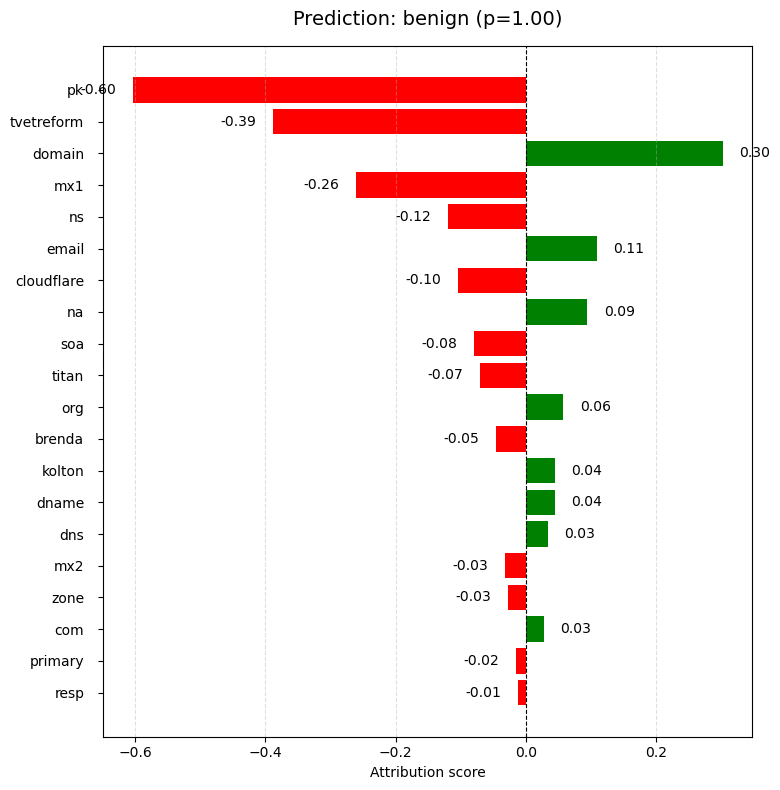

In [8]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 1) Load model + tokenizer ────────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) Prepare your DNS-record string ─────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)

enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]      # [1, L]
attention_mask = enc["attention_mask"] # [1, L]

# ─── 3) Compute prediction for display ────────────────────────────────────────
with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs      = torch.softmax(logits, dim=1)[0]
    pred_idx   = probs.argmax().item()
    pred_label = "malicious" if pred_idx == 1 else "benign"
    pred_conf  = probs[pred_idx].item()

# ─── 4) Get embeddings + run Integrated Gradients ────────────────────────────
embeds = model.distilbert.embeddings.word_embeddings(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_emb(x, mask):
    return model(input_ids=None, inputs_embeds=x, attention_mask=mask).logits[:, 1]

ig = IntegratedGradients(forward_emb)
attributions = ig.attribute(
    embeds,                           # positional inputs_embeds
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → [1, L] → [L], then detach + cpu + numpy
token_attrs = (
    attributions
      .sum(dim=-1)
      .squeeze(0)
      .detach()
      .cpu()
      .numpy()
)

raw_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) Merge subwords + drop standalone punctuation ─────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_tokens, raw_scores):
    if tok in tokenizer.all_special_tokens:
        continue
    if re.fullmatch(r"[^\w]+", tok):
        continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) Aggregate duplicate words ─────────────────────────────────────────────
agg = OrderedDict()
for w, s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s

words       = list(agg.keys())
word_scores = list(agg.values())

# ─── 7) Keep only the Top-K by absolute attribution ──────────────────────────
K = 20
order = np.argsort(np.abs(word_scores))[::-1][:K]
top_words  = [words[i] for i in order]
top_scores = [word_scores[i] for i in order]

# ─── 8) Plot with plenty of breathing room + prediction title ───────────────
num_bars = len(top_words)
fig_height = max(6, num_bars * 0.4)

fig, ax = plt.subplots(figsize=(8, fig_height))
plt.subplots_adjust(left=0.40, right=0.95, top=0.90, bottom=0.05)

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s > 0 else "red" for s in top_scores],
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)

# force labels just outside each bar, with extra padding
ax.bar_label(bars, fmt="%.2f", padding=12, label_type="edge")

# push y-tick labels away from the axis
ax.tick_params(axis="y", pad=10)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})", pad=15, fontsize=14)

plt.tight_layout()
plt.show()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_154904/1410204492.py:153: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


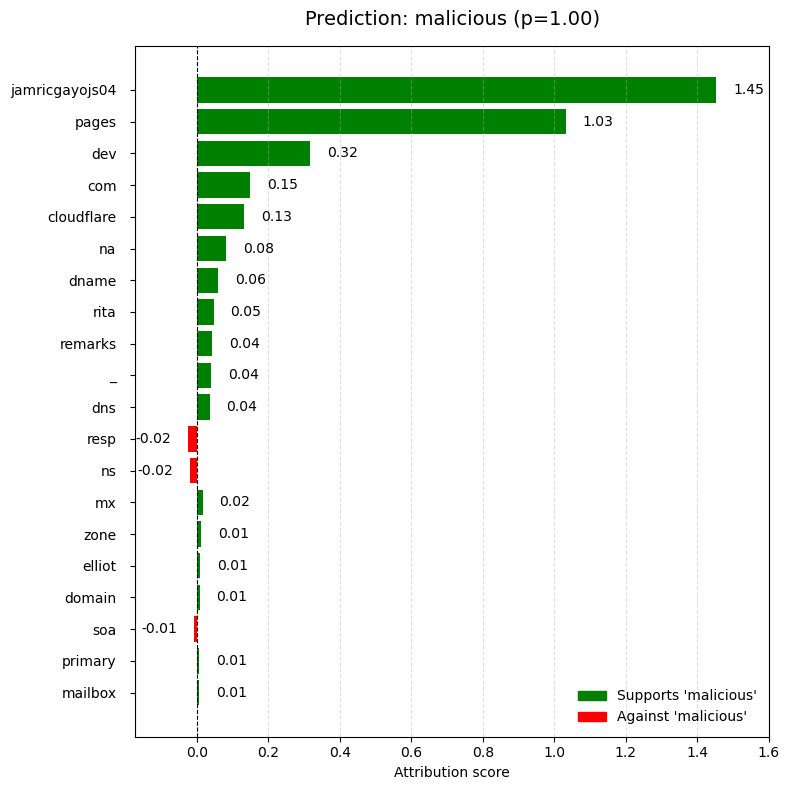

In [23]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 1) load model + tokenizer ───────────────────────────────────────────────

MODEL_CHECKPOINT = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) prepare DNS record ────────────────────────────────────────────────────

record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("[CLS] domain: jamricgayojs04.pages.dev [SEP] "
          "MX: NA [SEP] NS: elliot.ns.cloudflare.com, rita.ns.cloudflare.com [SEP] "
          "SOA: primary_ns: elliot.ns.cloudflare.com | resp_mailbox_dname: dns.cloudflare.com [SEP] "
          "zone_SOA: NA [SEP] remarks: zone: jamricgayojs04.pages.dev [SEP]"
)
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) model prediction ──────────────────────────────────────────────────────

with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs      = torch.softmax(logits, dim=1)[0]
    pred_idx   = probs.argmax().item()                # 0=benign, 1=malicious
    pred_label = ["benign","malicious"][pred_idx]
    pred_conf  = probs[pred_idx].item()

# ─── 4) Integrated Gradients on the *predicted* class logit ─────────────────

embeds   = model.distilbert.embeddings.word_embeddings(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_to_target(x, mask):
    logits = model(input_ids=None, inputs_embeds=x, attention_mask=mask).logits
    return logits[:, pred_idx]    # <— use whichever class was predicted

ig = IntegratedGradients(forward_to_target)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → [L], detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop stray punctuation ──────────────────────────────

words, word_scores = [], []
for tok, sc in zip(raw_tokens, raw_scores):
    if tok in tokenizer.all_special_tokens:
        continue
    if re.fullmatch(r"[^\w]+", tok):
        continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) aggregate duplicates ─────────────────────────────────────────────────

agg = OrderedDict()
for w, s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s

words       = list(agg.keys())
word_scores = list(agg.values())

# ─── 7) pick Top-K by |score| ────────────────────────────────────────────────

K = 20
order = np.argsort(np.abs(word_scores))[::-1][:K]
top_words  = [words[i] for i in order]
top_scores = [word_scores[i] for i in order]

# ─── 8) plot ─────────────────────────────────────────────────────────────────

# choose colors so that benign always green, malicious always red
if pred_idx == 0:
    # benign: positive bars = green, negative = red
    pos_col, neg_col = "green", "red"
    pos_label = f"Supports '{pred_label}'"
    neg_label = f"Against '{pred_label}'"
else:
    # malicious: positive bars = red, negative = green
    pos_col, neg_col = "red", "green"
    pos_label = f"Supports '{pred_label}'"
    neg_label = f"Against '{pred_label}'"

fig_height = max(6, len(top_words)*0.4)
fig, ax = plt.subplots(figsize=(8, fig_height), constrained_layout=True)
# plt.subplots_adjust(left=0.40, right=0.95, top=0.90, bottom=0.05)
# plt.subplots_adjust(left=0.50)

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s > 0 else "red" for s in top_scores],
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)

ax.margins(x=0.10)

# “edge”+padding so no numbers overlap, even back‐to‐back bars
ax.bar_label(bars, fmt="%.2f", padding=12, label_type="edge")
ax.tick_params(axis="y", pad=10)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})", pad=15, fontsize=14)

# ─── add legend ───────────────────────────────────────────────────────────────
pos_patch = mpatches.Patch(color="green", label=f"Supports '{pred_label}'")
neg_patch = mpatches.Patch(color="red",   label=f"Against '{pred_label}'")
ax.legend(handles=[pos_patch, neg_patch], loc="lower right", frameon=False)

plt.tight_layout()
plt.show()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_154904/2743002709.py:100: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.50)


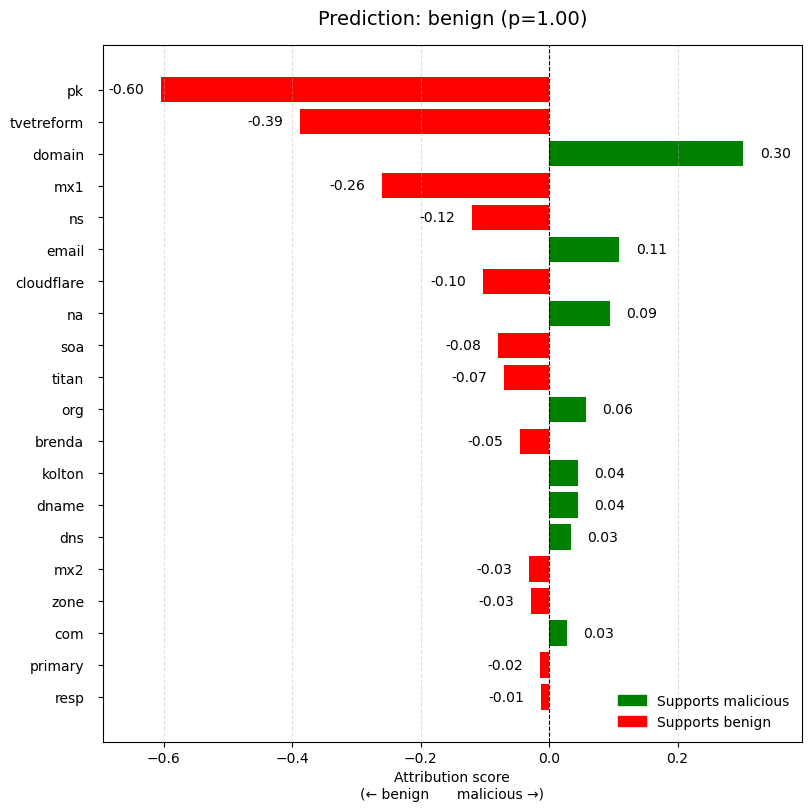

In [26]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from captum.attr import IntegratedGradients

# 1) Load model + tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# 2) Tokenize record
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
# record = ("[CLS] domain: jamricgayojs04.pages.dev [SEP] "
#           "MX: NA [SEP] NS: elliot.ns.cloudflare.com, rita.ns.cloudflare.com [SEP] "
#           "SOA: primary_ns: elliot.ns.cloudflare.com | resp_mailbox_dname: dns.cloudflare.com [SEP] "
#           "zone_SOA: NA [SEP] remarks: zone: jamricgayojs04.pages.dev [SEP]"
# )
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# 3) Get prediction (for title only)
with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs      = torch.softmax(logits, dim=1)[0]
    pred_idx   = probs.argmax().item()
    pred_label = ["benign","malicious"][pred_idx]
    pred_conf  = probs[pred_idx].item()

# 4) Integrated Gradients on the *malicious* logit (class 1)
embeds   = model.distilbert.embeddings.word_embeddings(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_malicious(x, mask):
    # always target the "malicious" logit (index=1)
    return model(input_ids=None, inputs_embeds=x, attention_mask=mask).logits[:, 1]

ig = IntegratedGradients(forward_malicious)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# 5) Merge subwords & drop punctuation
words, word_scores = [], []
for tok, sc in zip(raw_tokens, raw_scores):
    if tok in tokenizer.all_special_tokens: continue
    if re.fullmatch(r"[^\w]+", tok): continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# 6) Aggregate duplicates
agg = OrderedDict()
for w, s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# 7) Top-K filtering
K = 20
order = np.argsort(np.abs(word_scores))[::-1][:K]
top_words  = [words[i] for i in order]
top_scores = [word_scores[i] for i in order]

# 8) Plot “negative=benign, positive=malicious”
fig, ax = plt.subplots(figsize=(8, max(6, len(top_words)*0.4)), constrained_layout=True)
plt.subplots_adjust(left=0.50)

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]  # green→malicious, red→benign
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=12, label_type="edge")
ax.margins(x=0.10)
ax.tick_params(axis="y", pad=10)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← benign  malicious →)")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})", pad=15, fontsize=14)

# legend
pos_patch = mpatches.Patch(color="green", label="Supports malicious")
neg_patch = mpatches.Patch(color="red",   label="Supports benign")
ax.legend(handles=[pos_patch, neg_patch], loc="lower right", frameon=False)

plt.show()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_154904/2429133260.py:115: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.50)  # plenty of room on the left


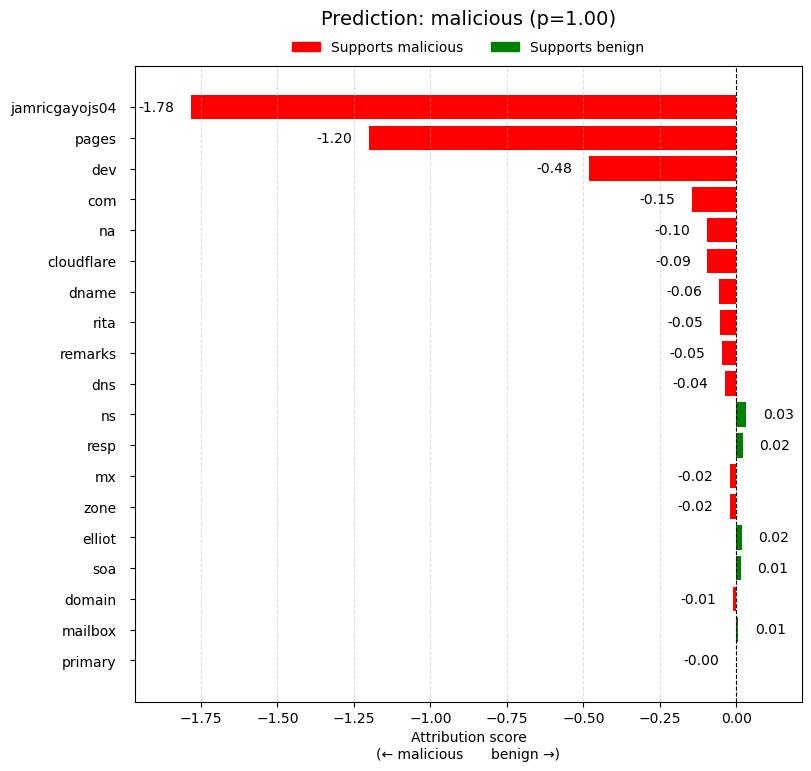

In [43]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 1) Load model + tokenizer ────────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model     = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) Prepare your DNS-record string ────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("[CLS] domain: jamricgayojs04.pages.dev [SEP] "
          "MX: NA [SEP] NS: elliot.ns.cloudflare.com, rita.ns.cloudflare.com [SEP] "
          "SOA: primary_ns: elliot.ns.cloudflare.com | resp_mailbox_dname: dns.cloudflare.com [SEP] "
          "zone_SOA: NA [SEP] remarks: zone: jamricgayojs04.pages.dev [SEP]"
)
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) Compute prediction for display ────────────────────────────────────────
with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs      = torch.softmax(logits, dim=1)[0]
    pred_idx   = probs.argmax().item()               # 0=benign, 1=malicious
    pred_label = ["benign","malicious"][pred_idx]
    pred_conf  = probs[pred_idx].item()

# ─── 4) Integrated Gradients targeting the benign logit ───────────────────────
embeds   = model.distilbert.embeddings.word_embeddings(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_benign(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 0]   # always target class=0 (benign)

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) Merge subwords + drop stray punctuation ───────────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_tokens, raw_scores):
    if tok in tokenizer.all_special_tokens:        continue
    if re.fullmatch(r"[^\w]+", tok):               continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) Aggregate duplicates ───────────────────────────────────────────────────
agg = OrderedDict()
for w, s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# ─── 7) Drop any 1-char tokens (just in case) ────────────────────────────────
filtered = [(w,s) for w,s in zip(words, word_scores) if len(w) > 1]
if filtered:
    words, word_scores = zip(*filtered)
else:
    words, word_scores = list(words), list(word_scores)

# ─── 8) Top-K filtering ───────────────────────────────────────────────────────
K = 20
order = np.argsort(np.abs(word_scores))[::-1][:K]
top_words  = [words[i] for i in order]
top_scores = [word_scores[i] for i in order]

# ─── 9) Plot: negative=malicious(red), positive=benign(green) ───────────────
fig, ax = plt.subplots(
    figsize=(8, max(6, len(top_words)*0.4)),
    constrained_layout=True
)
plt.subplots_adjust(left=0.50)  # plenty of room on the left

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=12, label_type="edge")
ax.margins(x=0.10)
ax.tick_params(axis="y", pad=10)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← malicious  benign →)")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})", pad=30, fontsize=14)

# legend: red supports malicious, green supports benign
red_patch   = mpatches.Patch(color="red",   label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
ax.legend(
    handles=[mpatches.Patch(color="red", label="Supports malicious"),
             mpatches.Patch(color="green", label="Supports benign")],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.06),
    ncol=2,
    frameon=False
)
# place it under the title, centered
# ax.legend(
#     handles=[red_patch, green_patch],
#     loc="upper center",               # anchor point of legend box
#     bbox_to_anchor=(0.5, 0.88),       # (x, y) in axes coords: 0.5=center, 0.88≈just below title
#     ncol=2,                           # two columns
#     frameon=False,
#     handletextpad=1.0,                # spacing between patch and text
#     columnspacing=1.5                 # spacing between columns
# )
# fig.legend uses figure coords: (0.5, 0.96) is centered, a bit below the top
# fig.legend(
#     handles=[red_patch, green_patch],
#     loc="upper center",
#     bbox_to_anchor=(0.5, 0.96),
#     ncol=2,
#     frameon=False,
#     handletextpad=1.0,
#     columnspacing=1.5,
#     fontsize=10,
# )
plt.show()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_154904/1993271088.py:126: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.50)  # room for negative labels


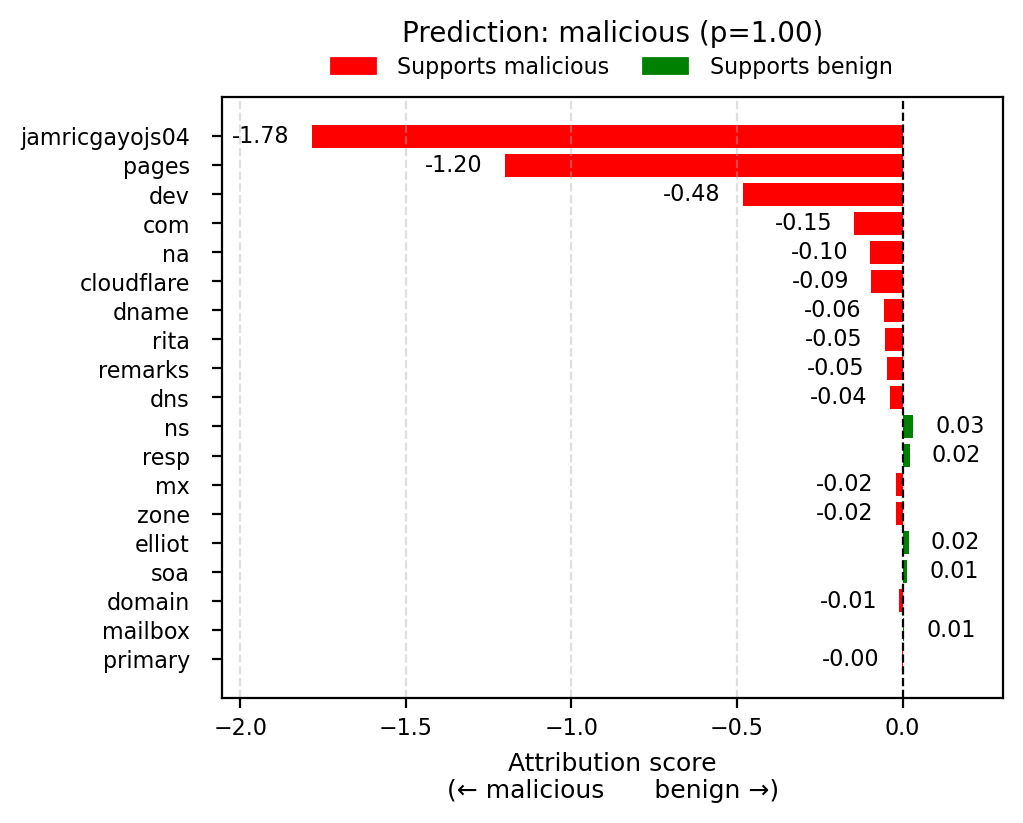

In [56]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 0) global font settings ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size":         8,    # base font size for tick labels, etc.
    "axes.titlesize":    10,   # title
    "axes.labelsize":    9,    # x/y axis labels
    "xtick.labelsize":   8,    # x-tick labels
    "ytick.labelsize":   8,    # y-tick labels
    "legend.fontsize":   8,    # legend text
})

# ─── 1) load model + tokenizer ───────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt"
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model     = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) your DNS record ───────────────────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("[CLS] domain: jamricgayojs04.pages.dev [SEP] "
          "MX: NA [SEP] NS: elliot.ns.cloudflare.com, rita.ns.cloudflare.com [SEP] "
          "SOA: primary_ns: elliot.ns.cloudflare.com | resp_mailbox_dname: dns.cloudflare.com [SEP] "
          "zone_SOA: NA [SEP] remarks: zone: jamricgayojs04.pages.dev [SEP]"
)
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) model prediction ──────────────────────────────────────────────────────
with torch.no_grad():
    logits    = model(input_ids, attention_mask=attention_mask).logits
    probs     = torch.softmax(logits, dim=1)[0]
    pred_idx  = probs.argmax().item()              # 0=benign, 1=malicious
    pred_lbl  = ["benign","malicious"][pred_idx]
    pred_conf = probs[pred_idx].item()

# ─── 4) Integrated Gradients targeting benign logit ──────────────────────────
embeds   = model.distilbert.embeddings.word_embeddings(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_benign(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 0]   # target class 0 = benign

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_toks   = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop punctuation ─────────────────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_toks, raw_scores):
    if tok in tokenizer.all_special_tokens:        continue
    if re.fullmatch(r"[^\w]+", tok):               continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) aggregate duplicates & drop 1-char tokens ────────────────────────────
agg = OrderedDict()
for w,s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# drop single-char remnants
filtered = [(w,s) for w,s in zip(words, word_scores) if len(w)>1]
if filtered:
    words, word_scores = zip(*filtered)
else:
    words, word_scores = list(words), list(word_scores)

# ─── 7) top-K by absolute score ───────────────────────────────────────────────
K = 20
order     = np.argsort(np.abs(word_scores))[::-1][:K]
top_words = [words[i]       for i in order]
top_scores= [word_scores[i]  for i in order]

# ─── 8) PLOT ──────────────────────────────────────────────────────────────────
# choose a smaller figure, but high DPI so text stays crisp
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words)*0.20)),
    dpi=200,
    constrained_layout=True,
)
plt.subplots_adjust(left=0.50)  # room for negative labels

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.tick_params(axis="y", pad=8)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← malicious  benign →)")
ax.set_title(f"Prediction: {pred_lbl} (p={pred_conf:.2f})", pad=20)


# legend just under the title
red_patch   = mpatches.Patch(color="red",   label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False,
    handletextpad=1,
    columnspacing=1.5
)

plt.show()


In [1]:
DGA_MODEL_NAME = "prajjwal1/bert-medium"
MALWARE_MODEL_NAME = "google/electra-base-discriminator"
PHISHING_MODEL_NAME = "distilbert-base-uncased"

# Domain names

## DGA

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-medium and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_165458/1536077920.py:123: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.50)  # room for negative labels


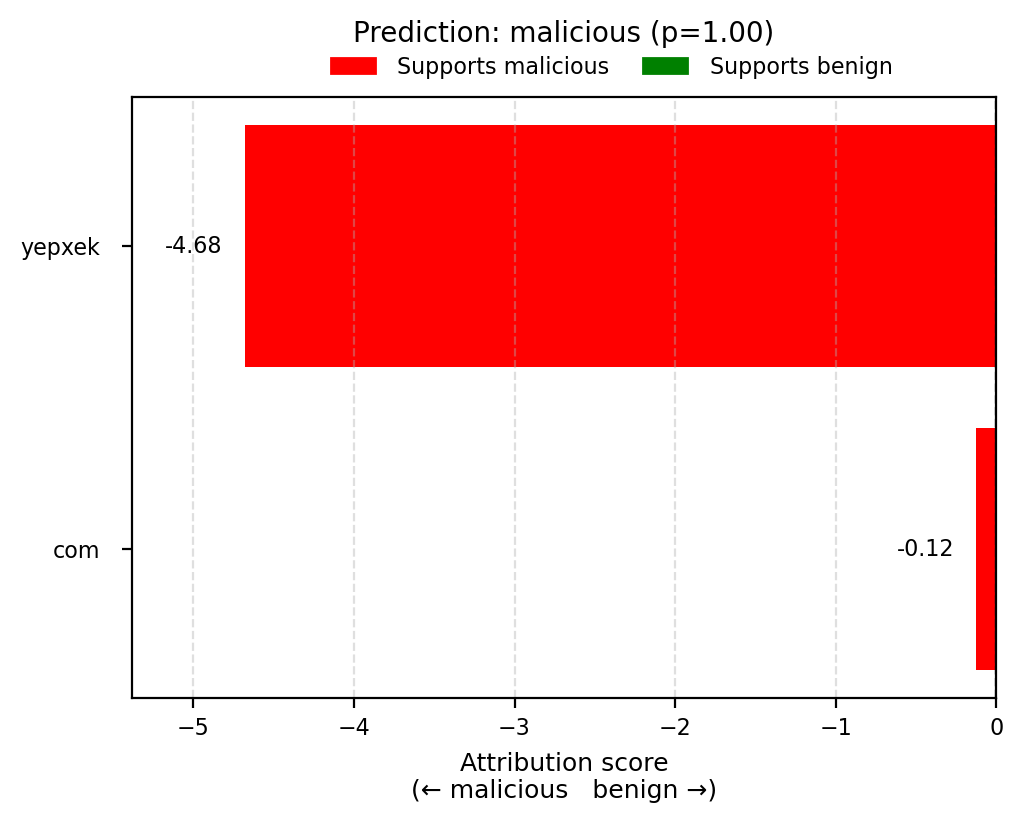

In [ ]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import  AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 0) global font settings ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size":         8,    # base font size for tick labels, etc.
    "axes.titlesize":    10,   # title
    "axes.labelsize":    9,    # x/y axis labels
    "xtick.labelsize":   8,    # x-tick labels
    "ytick.labelsize":   8,    # y-tick labels
    "legend.fontsize":   8,    # legend text
})

# ─── 1) load model + tokenizer ───────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/saved_models/BEST_dga_prajjwal1-bert-medium_20250503_145342.pt"
tokenizer = AutoTokenizer.from_pretrained(DGA_MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(
    DGA_MODEL_NAME, num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) your DNS record ───────────────────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("rr1---sn-n8v7znzl.googlevideo.com")
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) model prediction ──────────────────────────────────────────────────────
with torch.no_grad():
    logits    = model(input_ids, attention_mask=attention_mask).logits
    probs     = torch.softmax(logits, dim=1)[0]
    pred_idx  = probs.argmax().item()              # 0=benign, 1=malicious
    pred_lbl  = ["benign","malicious"][pred_idx]
    pred_conf = probs[pred_idx].item()

# ─── 4) Integrated Gradients targeting benign logit ──────────────────────────
embedding_layer = model.get_input_embeddings()
embeds   = embedding_layer(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_benign(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 0]   # target class 0 = benign

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_toks   = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop punctuation ─────────────────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_toks, raw_scores):
    if tok in tokenizer.all_special_tokens:        continue
    if re.fullmatch(r"[^\w]+", tok):               continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) aggregate duplicates & drop 1-char tokens ────────────────────────────
agg = OrderedDict()
for w,s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# drop single-char remnants
filtered = [(w,s) for w,s in zip(words, word_scores) if len(w)>1]
if filtered:
    words, word_scores = zip(*filtered)
else:
    words, word_scores = list(words), list(word_scores)

# ─── 7) top-K by absolute score ───────────────────────────────────────────────
K = 20
order     = np.argsort(np.abs(word_scores))[::-1][:K]
top_words = [words[i]       for i in order]
top_scores= [word_scores[i]  for i in order]

# ─── 8) PLOT ──────────────────────────────────────────────────────────────────
# choose a smaller figure, but high DPI so text stays crisp
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words)*0.20)),
    dpi=200,
    constrained_layout=True,
)
plt.subplots_adjust(left=0.50)  # room for negative labels

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.tick_params(axis="y", pad=8)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← malicious   benign →)")
ax.set_title(f"Prediction: {pred_lbl} (p={pred_conf:.2f})", pad=20)


# legend just under the title
red_patch   = mpatches.Patch(color="red",   label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False,
    handletextpad=1,
    columnspacing=1.5
)

plt.show()
